/home/otsukalab/.local/share/virtualenvs/reparam-cfaYz6qU/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/home/otsukalab/.local/share/virtualenvs/reparam-cfaYz6qU/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


CPU times: user 8min 38s, sys: 4min 19s, total: 12min 58s
Wall time: 2min 52s


/home/otsukalab/.local/share/virtualenvs/reparam-cfaYz6qU/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/home/otsukalab/.local/share/virtualenvs/reparam-cfaYz6qU/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


CPU times: user 5min 53s, sys: 4min 37s, total: 10min 30s
Wall time: 1min 17s
CPU times: user 27min 31s, sys: 10min 35s, total: 38min 7s
Wall time: 8min 23s


Text(0.5, 1.02, 'thin_support_bridge_128x128_0.2')

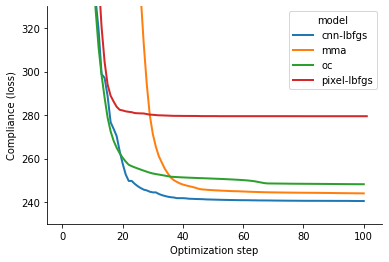

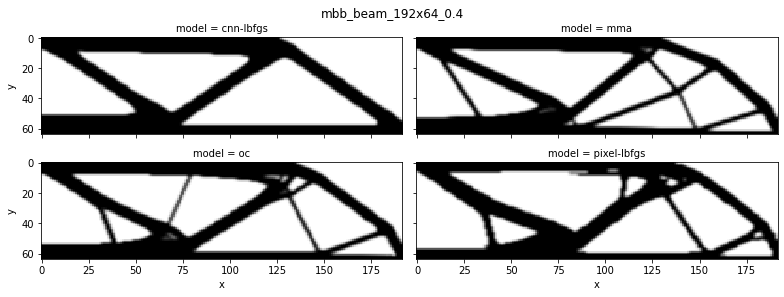

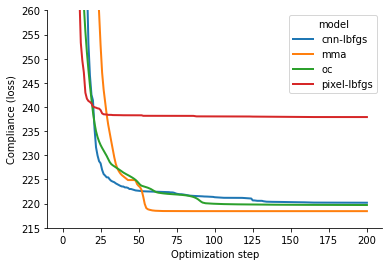

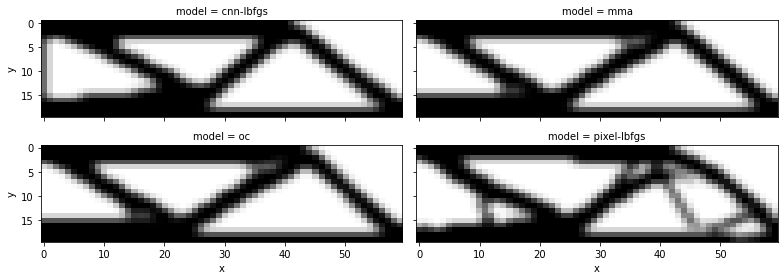

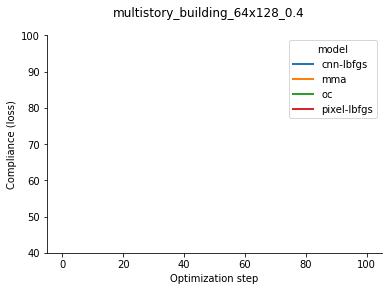

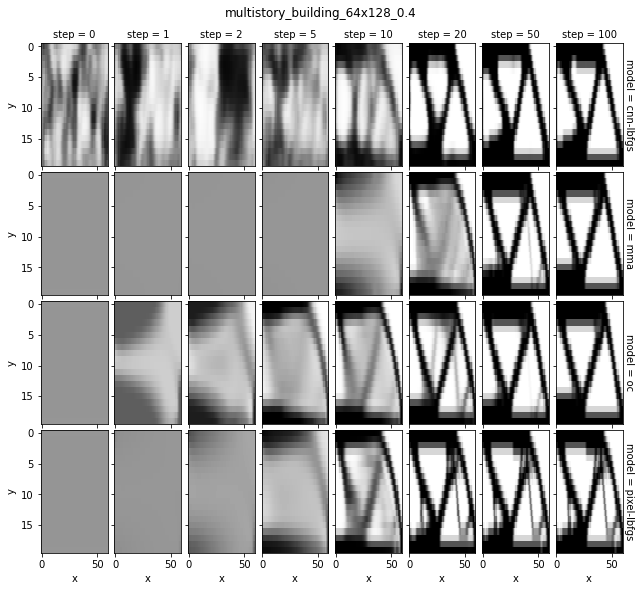

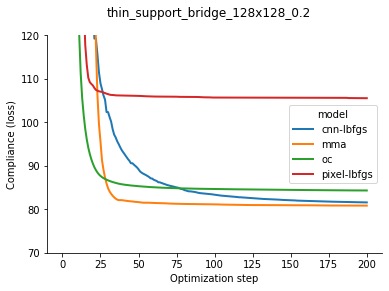

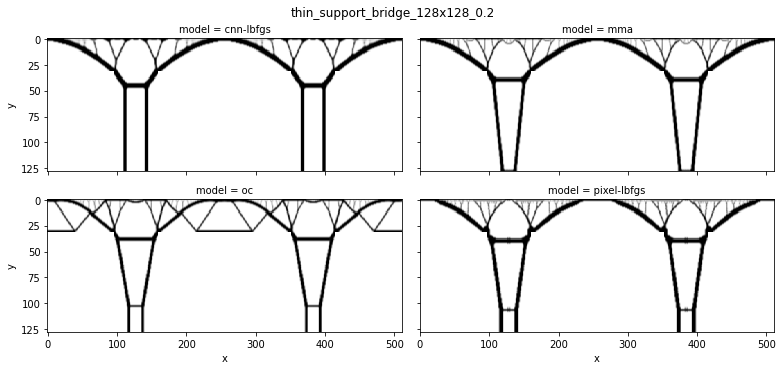

In [7]:
from IPython import display
from PIL import Image
import seaborn
import matplotlib.pyplot as plt
import xarray
import pandas as pd

from neural_structural_optimization.Opt_2DModel_20201206 import pipeline_utils
from neural_structural_optimization.Opt_2DModel_20201206 import problems
from neural_structural_optimization.Opt_2DModel_20201206 import models
from neural_structural_optimization.Opt_2DModel_20201206 import topo_api
from neural_structural_optimization.Opt_2DModel_20201206 import train


def train_all(problem, max_iterations, cnn_kwargs=None):
    args = topo_api.specified_task(problem)
    if cnn_kwargs is None:
        cnn_kwargs = {}

    model = models.PixelModel(args=args)
    ds_mma = train.method_of_moving_asymptotes(model, max_iterations)

    model = models.PixelModel(args=args)
    ds_oc = train.optimality_criteria(model, max_iterations)

    model = models.PixelModel(args=args)
    ds_pix = train.train_lbfgs(model, max_iterations)

    model = models.CNNModel(args=args, **cnn_kwargs)
    ds_cnn = train.train_lbfgs(model, max_iterations)

    dims = pd.Index(['cnn-lbfgs', 'mma', 'oc', 'pixel-lbfgs'], name='model')
    return xarray.concat([ds_cnn, ds_mma, ds_oc, ds_pix], dim=dims)

#"MBB beam with a larger grid"
problem = problems.PROBLEMS_BY_NAME['mbb_beam_192x64_0.4']
max_iterations = 100
%time ds = train_all(problem, max_iterations)

ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylim(230, 330)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()

# the pixel-lbfgs does not run for the full 100 steps (it terminates
# early due to reaching a local minima), so use fill() to forward fill
# to the last valid design.
ds.design.ffill('step').sel(step=100).plot.imshow(
    col='model', x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')
plt.suptitle(problem.name, y=1.02)


# "MBB Beam (Figure 2 from paper)"

problem = problems.mbb_beam(height=20, width=60)
max_iterations = 200

# can't upscale by exactly 8x for a 60x20 design region, so upscale by
# only 4x instead
%time ds = train_all(problem, max_iterations, cnn_kwargs=dict(resizes=(1, 1, 2, 2, 1)))

ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylim(215, 260)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()

ds.design.sel(step=200).plot.imshow(
    col='model', x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

def save_gif_movie(images, path, duration=200, loop=0, **kwargs):
    images[0].save(path, save_all=True, append_images=images[1:],
                   duration=duration, loop=loop, **kwargs)

images = [
    pipeline_utils.image_from_design(design, problem)
    for design in ds.design.sel(model='cnn-lbfgs')[:100]
]

save_gif_movie([im.resize((5*120, 5*20)) for im in images], 'movie.gif')


#"Multistory building"
problem = problems.PROBLEMS_BY_NAME['multistory_building_64x128_0.4']
max_iterations = 100  # keep things fast
# %time ds = train_all(problem, max_iterations)

ds.loss.transpose().to_pandas().cummin().loc[:100].plot(linewidth=2)
plt.ylim(40, 100)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()
plt.suptitle(problem.name)

ds.design.sel(step=[0, 1, 2, 5, 10, 20, 50, 100]).plot.imshow(
    row='model', col='step', x='x', y='y', size=2, aspect=0.5,
    yincrease=False, add_colorbar=False, cmap='Greys')
plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.suptitle(problem.name, y=1.02)


#"Thin support bridge"
# we really need more iterations to see the CNN-LBFGS method dominate
problem = problems.PROBLEMS_BY_NAME['thin_support_bridge_128x128_0.2']
max_iterations = 200
%time ds = train_all(problem, max_iterations)

ds.loss.transpose().to_pandas().cummin().plot(linewidth=2)
plt.ylim(70, 120)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()
plt.suptitle(problem.name)

(xarray.concat([ds.design, ds.design.sel(x=slice(None, None, -1))] * 2, dim='x')
 .sel(step=200)
 .plot.imshow(
    col='model', x='x', y='y', size=2.5, aspect=2, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys'))
plt.suptitle(problem.name, y=1.02)
